# Backtrader tutorial

Start by importing pandas, the OpenBB SDK, QuantStats, and Backtrader.

In [1]:
import datetime as dt

import pandas as pd

from openbb_terminal.sdk import openbb
import backtrader as bt

There’s an unsolved issue with Backtrader that prevents it from downloading data. Here’s a simple workaround. This function downloads the data from the OpenBB SDK, converts it to a CSV, and reads it into Backtrader’s `YahooFinanceCSVData`.

In [2]:
def openbb_data_to_bt_data(symbol, start_date, end_date):
    df = openbb.stocks.load(symbol, start_date=start_date, end_date=end_date)
    fn = f"{symbol.lower()}.csv"
    df.to_csv(fn)
    return bt.feeds.YahooFinanceCSVData(
        dataname=fn,
        fromdate=dt.datetime.strptime(start_date, '%Y-%m-%d'),
        todate=dt.datetime.strptime(end_date, '%Y-%m-%d')
    )

Next, setup the Backtrader strategy. All Backtrader strategies are built as classes and inherit `bt.Strategy`.

The [strategy documentation](https://www.backtrader.com/docu/strategy/) is the best place to get familiar with everything you can do.

In [40]:
class SmaStrategy(bt.Strategy):
    params = (("ma_period", 20), )
    
    def __init__(self):
        self.order = None
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)
        
    def log(self, txt):
        dt_ = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt_}: {txt}")
        
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            direction = "BUY" if order.isbuy() else "SELL"
            self.log(f"Executed {direction} of {order.executed.size} at {order.executed.price}")
        
        elif order.status in [
            order.Canceled, 
            order.Margin,
            order.Rejected
        ]:
            self.log("Order Failed")
        
        self.order = None
        
    def notify_trade(self, trade):
        
        if not trade.isclosed:
            return
        
        self.log(f"PnL: Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}")
        
    def next(self):
        
        if self.order:
            return
        
        # no open position
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.log(f"Created BUY of 1 at {self.data_close[0]}")
                self.order = self.buy()
        # position
        else:
            if self.data_close[0] < self.sma[0]:
                self.log(f"Created SELL of 1 at {self.data_close[0]}")
                self.order = self.sell()
        
    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")
        
    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

Backtrader is based on its core engine called Cerebro. The first step is to create the backtesting engine.

In [41]:
cerebro = bt.Cerebro(stdstats=False)

Next, download the data you need for the backtest and add it to the engine. This just lets the backtest engine know there's data available. Data feeds are added to Cerebro instances and end up being part of the input of strategies (parsed and served as attributes of the instance).

In [42]:
data = openbb_data_to_bt_data("ORCL", start_date="2010-01-01", end_date="2021-12-31")
cerebro.adddata(data)

Loading Daily data for ORCL with starting period 2010-01-04.

Next, set the initial cash and commission model for the backtest. Commission models can get complex. In this example, it's just 0.1% per trade.

In [43]:
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)

Add the strategy you built above.

In [44]:
cerebro.addstrategy(SmaStrategy)

0

Observers are class that track (or observe) metrics through time. They're used to later plot those metrics throughout the backest. When you initiated the Cerebro engine above, you included `stdstats=False`. You can also set that to `True` to plot the defalt metrics (portfolio balance, trades, and buy/sell annotations). In this case, you add a built in observer to print the value (i.e. equity) of the strategy.

In [45]:
cerebro.addobserver(bt.observers.Value)

Be it backtesting or trading, being able to analyze the performance of the trading system is key to understanding if not only profit has been attained, but also if it has been achieved with too much risk or if it was really worth the effort when compared to a benchmark.

That’s where the family of Analyzers comes in: they provide an analysis of what happened.

In [46]:
# Total, Average, Compound and Annualized Returns calculated using a logarithmic approach
cerebro.addanalyzer(
    bt.analyzers.Returns, _name="returns"
)

# This analyzer calculates the Returns by looking at the beginning and end of the timeframe
cerebro.addanalyzer(
    bt.analyzers.TimeReturn, _name="time_return"
)

With the backtest setup, it's time to run it. By returning the result to a variable, you get access to the output from the observers and analyzers. Each action is logged along with the profit or loss at the end of each round trip.

In [47]:
backtest_result = cerebro.run()

Initial Portfolio Value: 1000.00
2010-02-16: Created BUY of 1 at 19.92
2010-02-17: Executed BUY of 1 at 20.04
2010-04-27: Created SELL of 1 at 21.78
2010-04-28: Executed SELL of -1 at 21.81
2010-04-28: PnL: Gross: 1.77, Net: 1.73
2010-06-11: Created BUY of 1 at 19.02
2010-06-14: Executed BUY of 1 at 19.3
2010-06-24: Created SELL of 1 at 18.63
2010-06-25: Executed SELL of -1 at 19.4
2010-06-25: PnL: Gross: 0.10, Net: 0.06
2010-06-25: Created BUY of 1 at 19.0
2010-06-28: Executed BUY of 1 at 19.15
2010-06-28: Created SELL of 1 at 18.82
2010-06-29: Executed SELL of -1 at 18.46
2010-06-29: PnL: Gross: -0.69, Net: -0.73
2010-07-07: Created BUY of 1 at 19.36
2010-07-08: Executed BUY of 1 at 19.4
2010-08-11: Created SELL of 1 at 19.88
2010-08-12: Executed SELL of -1 at 19.53
2010-08-12: PnL: Gross: 0.13, Net: 0.09
2010-09-03: Created BUY of 1 at 19.26
2010-09-07: Executed BUY of 1 at 20.63
2010-11-09: Created SELL of 1 at 24.19
2010-11-10: Executed SELL of -1 at 24.11
2010-11-10: PnL: Gross: 

2020-10-02: Created SELL of 1 at 56.51
2020-10-05: Executed SELL of -1 at 57.09
2020-10-05: PnL: Gross: 1.92, Net: 1.81
2020-10-05: Created BUY of 1 at 57.21
2020-10-06: Executed BUY of 1 at 57.16
2020-10-19: Created SELL of 1 at 57.5
2020-10-20: Executed SELL of -1 at 57.79
2020-10-20: PnL: Gross: 0.63, Net: 0.52
2020-11-24: Created BUY of 1 at 55.52
2020-11-25: Executed BUY of 1 at 55.67
2021-01-06: Created SELL of 1 at 60.57
2021-01-07: Executed SELL of -1 at 60.85
2021-01-07: PnL: Gross: 5.18, Net: 5.06
2021-01-07: Created BUY of 1 at 61.06
2021-01-08: Executed BUY of 1 at 61.16
2021-01-11: Created SELL of 1 at 61.02
2021-01-12: Executed SELL of -1 at 60.99
2021-01-12: PnL: Gross: -0.17, Net: -0.29
2021-01-27: Created BUY of 1 at 60.55
2021-01-28: Executed BUY of 1 at 60.55
2021-01-28: Created SELL of 1 at 59.27
2021-01-29: Executed SELL of -1 at 59.21
2021-01-29: PnL: Gross: -1.34, Net: -1.46
2021-02-02: Created BUY of 1 at 60.38
2021-02-03: Executed BUY of 1 at 60.2
2021-02-17: C

<IPython.core.display.Javascript object>


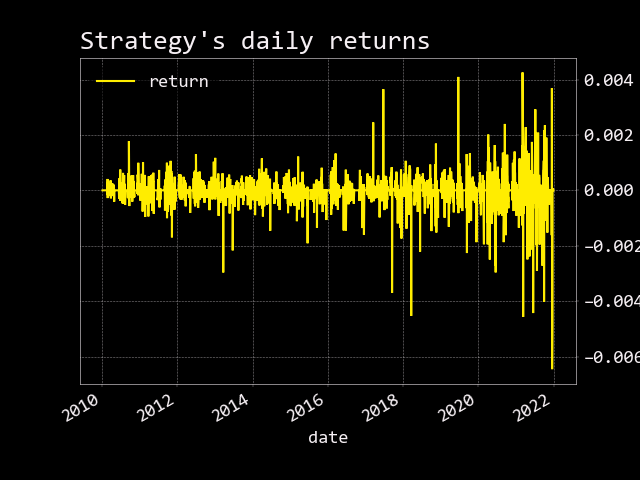

In [48]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = (
    pd.DataFrame(
        list(returns_dict.items()),
        columns = ["date", "return"]
    )
    .set_index("date")
)
returns_df.plot(title="Strategy's daily returns")

<IPython.core.display.Javascript object>


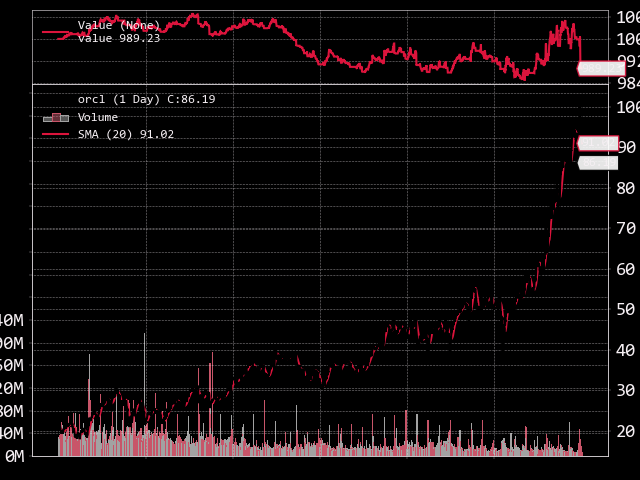

[[<Figure size 640x480 with 3 Axes>]]

In [49]:
# Plot the result
# requires matplotlib=3.2.2
cerebro.plot()